In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import os
import subprocess
plt.rc('text', usetex=True)

In [95]:
#Defining functions for plotting 3D grid to visualize temporal evolution of Temperature on the surface

def get_grid(mx, my, mz, Lx,Ly,Lz):
    #print('mx,my,mz = ',mx,my,mz)
    ix, iy, iz = Lx*np.linspace(0,1,mx), Ly*np.linspace(0,1,my), Lz*np.linspace(0,1,mz)
    x, y, z = np.meshgrid(ix,iy,iz, indexing='ij')
    #print('ix', ix), print('iy', iy), print('iz', iz)
    return x,y,z

def plot_grid(x,y,z,T, t, filename):
    def plot_boundary_only(x,y,z,T):
        #mx, my, mz = x.shape
        x[1:-1, 1:-1, 1:-1],y[1:-1, 1:-1, 1:-1],z[1:-1, 1:-1, 1:-1],T[1:-1, 1:-1, 1:-1] = np.nan, np.nan, np.nan, np.nan \
                #This removes interior because we cannot see it anyway? reduces time to plot
        return x,y,z,T
    
    x,y,z,T = plot_boundary_only(x,y,z,T)   
    fig = plt.figure(figsize=(15,15), facecolor = 'w')
    ax = fig.add_subplot(111, projection='3d')
    img = ax.scatter(x,y,z, c=T.reshape(-1), s=150, vmin = -5, vmax = 30, cmap=plt.inferno())
    cbar = fig.colorbar(img, orientation='horizontal', fraction=0.047, pad=0.01, aspect=15)
    plt.tick_params(axis='both', which='major', labelsize=18)
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(r'Temperature ($^oC$)', size = 22)
    
    ax.text(0,0,-15, 't = %i days'%t, fontsize=20)
    ax.set_xticklabels(['%i'%(l*W/Nw) for l in ax.get_xticks()])
    ax.set_yticklabels(['%i'%(l*L/Nl/1e3) for l in ax.get_yticks()])
    ax.set_zticklabels(['%i'%(l*D/Nd) for l in ax.get_zticks()])
    ax.set_ylabel('Length (km)', labelpad=20, fontsize=20)
    ax.set_xlabel('Width (m)', labelpad=20, rotation=0, fontsize=20)
    ax.set_zlabel('Depth from surface (m)', rotation=0, fontsize=20)
    ax.invert_zaxis()
    ax.view_init(15, -20)
    #plt.tight_layout()
    #plt.savefig('tempevolution_plots/temp%s.png'%count)
    plt.savefig(filename, bbox_inches='tight')
    plt.show()
    
def init_T(x,y,z, T_3d):
    #print('size of y = ', np.shape(y))
    T = np.zeros_like(x)
    #print('Size of T = ',np.shape(T))
    T = T_3d
    return T
def show_plot(crust, t):
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    im = ax.imshow(crust, vmin=0, vmax=20, cmap = 'inferno', aspect = 1 * (Nw/Nd))
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('$\mathrm{Temperature\ [K]}$', rotation=270, labelpad=15)
    ax.set_title('$\mathrm{t = %i\ days}$'%t)
    ax.set_xlabel('$\mathrm{Width}$')
    ax.set_ylabel('$\mathrm{Depth}$')


In [86]:
# Defining constants (surface properties set for Earth vals)

Tinit = 10 # C
Tvar = 12 # C
Tbottom = 11 # C
Tday = 7 # C

# Diffusion constant (https://www.nature.com/articles/nature07818)
#alpha = 0.0864 # m^2 / day
alpha = 0.389 #m^2 / day (https://terra-docs.s3.us-east-2.amazonaws.com/IJHSR/Articles/volume4-issue3/2022_43_p17_Murgia.pdf)

# times 
tyear = 11.2 # days in a year of proxima b
tday = 1 # d
ti = 0 # d
tf = 20*tyear # d
dt = 0.05 # d

# Depth, width, length
D = 10 # m
Nd = 40
W = 40 # m
Nw = 50
L = 4e6 # m
Nl = 100
ad = D/Nd
al = L/Nl

In [87]:
# Read in flare info from Vida+2019
energy = np.genfromtxt('vida+2019_flares.txt', usecols=3, skip_header=2)
elen = len(energy)
# Probability of a flare occuring in dt = number of flares / number of dt in 50 days 
flare_prob = elen / (50/dt)

# energy = np.append(energy, 1e34)

# Ergs in a given dt:
pcen_energy = 6.03e30 * 24*60*60 * dt
flare_factor = 4.8*energy / pcen_energy * (Tinit+Tvar+Tday)

In [ ]:
# Serial version of the solver along with plotting codes.

#Initialize "crust": 2D array of T = Tinit except at bottom
crust = np.full((Nd,Nl), Tinit, dtype='float')
crust[Nd-1] = Tbottom

count = 0

# Adjust dt to stability condition
if ((dt*alpha/ad**2 > 0.5) or (dt*alpha/al**2 > 0.5)):
        dt = 0.5*min(ad,al)**2/alpha
        print(t, ': dt adjusted to {}'.format(dt))

for t in np.arange(ti, tf+dt, dt):
    
    # Randomly choose if a flare happens; if yes, pick from the flare list. 
    if np.random.rand() < flare_prob:
        idx = np.random.randint(elen)
        flare_change = flare_factor[idx]
        print('Careful, flare at t = %.2f days! id = %i, Tchange = %.2E K '%(
            t, idx, flare_factor[idx]))
    else:
        flare_change = 0
    
    # Periodic heating at surface with phase shift and flaring
    phase = np.arange(Nl)/Nl
    crust[0] = (Tinit + 
                Tvar*np.sin(2*np.pi*(t/tyear+phase)) + 
                Tday*np.sin(2*np.pi*(t/tday + phase)) + 
                flare_change)
        
    # depth (skipping top and bottom to maintain boundaries)
    for i in range(1, Nd-1):
        # width (periodic boundary connecting 0 to Nw)
        for j in range(0, Nl-1):
            # evolve crust with FTCS approach! (in 2D)
            
            if j == Nl-1: # to avoid overflow at crust[i,j+1]
                crust[i,j] = crust[i,j] + dt*alpha*(
                    (crust[i+1,j] + crust[i-1,j] - 2*crust[i,j])/ad**2 + 
                    (crust[i,0] + crust[i,j-1] - 2*crust[i,j])/al**2)
            else:
                crust[i,j] = crust[i,j] + dt*alpha*(
                    (crust[i+1,j] + crust[i-1,j] - 2*crust[i,j])/ad**2 + 
                    (crust[i,j+1] + crust[i,j-1] - 2*crust[i,j])/al**2)
    
    # Show plot
#     if t%(tyear//5) == 0:
    if t%1 == 0:
        crust_3d = np.zeros((Nw,Nl,Nd))

        for i in range(Nw):
            crust_3d[i,:,:] = crust.T
        
        #show_plot(crust, t)
        #plt.show()
        nx, ny, nz = Nw, Nl, Nd
        Lx, Ly, Lz = nx-1, ny-1, nz-1
        x,y,z = get_grid(nx, ny, nz, Lx,Ly,Lz)  # generate a grid with mesh size Δx = Δy = Δz = 1
        T = init_T(x,y,z, crust_3d)
        filename = 'tempevolution_plots/temp'+str(count).zfill(3)+'.png'
        plot_grid(x,y,z,T, t, filename)
        #print('File {} saved \n'.format(filename))
        count += 1

#creating the animation
#print('Creating animation...')
#os.system('ffmpeg -i tempevolution_plots/temp%03d.png  -c:v libx264 -r 8 -pix_fmt yuv420p -vf \
#                    "scale=trunc(iw/2)*2:trunc(ih/2)*2" tempevolution_plots/surface_temp_final.mp4')
#print('animation created and saved')

In [ ]:
#Parallel version of the code. 'heat_ftcs_parallel.py' in the repo has the working version of the code as well which can be run with mpirun

comm  = MPI.COMM_WORLD
Ntasks = comm.Get_size()
ThisTask = comm.Get_rank()


# Constants (currently set for Earth vals)

Tinit = 10 # C
Tvar = 12 # C
Tbottom = 11 # C

# Diffusion constant (https://www.nature.com/articles/nature07818)
alpha = 0.0864 # m^2 / day
#alpha = 0.389 #m^2 / day (https://terra-docs.s3.us-east-2.amazonaws.com/IJHSR/Articles/volume4-issue3/2022_43_p17_Murgia.pdf)

# times
tyear = 11.2 # days in a year of proxima b
ti = 0 # d
tf = 1*tyear # d
dt = 0.1 # d

Temp_day = 7 #C
tday = 1 #day

# Depth, width, length (need to keep dt < a**2/(2*alpha))
D = 10 # m
Nd = 40
W = 50 # m
Nw = 50
L = 4e6 # m
Nl = 100
ad = D/Nd
al = L/Nl


#We will be deviding the 2D array colum-wise among the tasks

index_high = int(((ThisTask + 1) * Nl) / Ntasks) #setting upper bound of column no for each task
index_low = int((ThisTask * Nl) / Ntasks)  #setting lower bound of column no for each task
del_index = int(Nl / Ntasks) #For now please provide Ntasks such that del_index is automatically int
#print('del_index = {}'.format(del_index))
#sys.stdout.flush()


# Read in flare info from Vida+2019
energy = np.genfromtxt('vida+2019_flares.txt', usecols=3, skip_header=2)
elen = len(energy)
# Probability of a flare occuring in dt = number of flares / number of dt in 50 days 
flare_prob = elen / (50/dt)

# energy = np.append(energy, 1e34)

# Ergs in a given dt:
pcen_energy = 6.03e30 * 24*60*60 * dt
flare_factor = 4.8*energy / pcen_energy * (Tinit+Tvar+Temp_day)


crust = np.full((Nd,Nl), Tinit, dtype='float')
#crust = np.ones((Nd,Nl), dtype = 'float') * Tinit
crust[Nd-1] = Tbottom

#initializing the cells
cell_left = np.zeros(1)
cell_right = np.zeros(1)
#cell_upper = np.zeros(1)
#cell_lower = np.zeros(1)


count = 0 #for plotting

if ( (dt*alpha/ad**2 > 0.5) or (dt*alpha/al**2 > 0.5)):
    dt = 0.5*min(ad,al)**2/alpha
    print('dt adjusted to {}'.format(dt))
    sys.stdout.flush()
for t in np.arange(ti, tf+dt, dt):
    # Randomly choose if a flare happens; if yes, pick from the flare list. 
    if np.random.rand() < flare_prob:
        idx = np.random.randint(elen)
        flare_change = flare_factor[idx]
        print('Careful, flare at t = %.2f days! id = %i, Tchange = %.2E K '%(
            t, idx, flare_factor[idx]))
    else:
        flare_change = 0
    

    # periodic heating at surface with phase shift (INCORRECT ON SUB-DAY TIMESCALE)
    phase = np.arange(Nl)/Nl
    crust[0] = Tinit + Tvar*np.sin(2*np.pi*(t/tyear+phase)) + Temp_day*np.sin(2*np.pi*(t/tday + phase)) + flare_change

    crust_thistask = crust[:,index_low:index_high]
    nrow, ncol = np.shape(crust_thistask)
    #print('Shape of crust_thistask is= {}, in task = {}'.format(np.shape(crust_thistask), ThisTask))
    #sys.stdout.flush()

    print('Parallelization begins......')
    sys.stdout.flush()

    if ThisTask == 0 : #rank == 0
        for i in range(1,nrow-1):
            for j in range(0,ncol-1):
                if ((j-1) < index_low):
                    #cell_left = comm.irecv(source = Ntasks-1, tag = Ntasks-1)
                    #print('Left cell received at task {} of {} from task {}'.format(ThisTask, Ntasks, Ntasks-1))
                    #sys.stdout.flush()
                    #cell_right = crust_thistask[i,j+1]
                    cell_left = np.zeros(1)
                    comm.isend(crust_thistask[i,j], dest = Ntasks-1, tag = 0)
                    #print('Right cell sent from task {} of {} to task {}'.format(ThisTask, Ntasks, Ntasks-1))
                    #sys.stdout.flush()
                    #print('Waiting to receive left cell at task {}'.format(ThisTask))
                    cell_left_req = comm.irecv(cell_left, source = Ntasks-1, tag = Ntasks-1)
                    #cell_left_req.wait()
                    #print('Left cell received at task {} of {} from task {}'.format(ThisTask, Ntasks, Ntasks-1))
                    #sys.stdout.flush()
                    cell_left = cell_left[0]
                    cell_right = crust_thistask[i,j+1]
                    cell_upper = crust_thistask[i+1,j]
                    cell_lower = crust_thistask[i-1,j]
                elif ((j+1) > index_high):
                    cell_left = crust_thistask[i,j-1]
                    #print('Waiting to receive left cell at task {}'.format(ThisTask))
                    cell_right = np.zeros(1)
                    cell_right_req = comm.irecv(cell_right, source = 1, tag = 1)
                    #cell_right_req.wait()
                    #print('Right cell received at task {} of {} from task {}'.format(ThisTask, Ntasks, 1))
                    #sys.stdout.flush()
                    cell_right = cell_right[0]
                    comm.isend(crust_thistask[i,j], dest = 1, tag = 0)
                    #print('Left cell sent from task {} of {} to task {}'.format(ThisTask, Ntasks, 1))
                    #sys.stdout.flush()
                    cell_upper = crust_thistask[i+1,j]
                    cell_lower = crust_thistask[i-1,j]
                else:
                    cell_upper = crust_thistask[i+1,j]
                    cell_lower = crust_thistask[i-1,j]
                    cell_right = crust_thistask[i,j+1]
                    cell_left = crust_thistask[i,j-1]
                    #print('This is not a edge cell at task {}'.format(ThisTask))
                    #sys.stdout.flush()
                crust_thistask[i,j] = crust_thistask[i,j] + dt * alpha * \
                                      ( (cell_upper + cell_lower - 2 * crust_thistask[i,j] ) / ad**2 + \
                                      (cell_right + cell_left - 2 * crust_thistask[i,j]) / al**2 )




    elif ThisTask != 0 : #for all the other tasks
        for i in range(1,nrow-1):
            for j in range(0,ncol-1):
                if ((j-1) < index_low):
                    comm.isend(crust_thistask[i,j], dest=ThisTask-1, tag = ThisTask)
                    #print('Right cell sent from task {} of {} to task {}'.format(ThisTask, Ntasks, ThisTask-1))
                    #sys.stdout.flush()
                    cell_left = np.zeros(1)
                    #print('Waiting to receive left cell at task {}'.format(ThisTask))
                    cell_left_req = comm.irecv(cell_left, source = ThisTask-1, tag = ThisTask-1)
                    #cell_left_req.wait()
                    #print('Left cell received at task {} of {} from task {}'.format(ThisTask, Ntasks, ThisTask-1))
                    #sys.stdout.flush()
                    cell_left = cell_left[0]
                    cell_right = crust_thistask[i,j+1]
                    cell_upper = crust_thistask[i+1,j]
                    cell_lower = crust_thistask[i-1,j] 
                elif ((j+1) > index_high): #if left cell needs to come from another task
                    if (ThisTask < Ntasks-1):
                        comm.isend(crust_thistask[i,j], dest = ThisTask+1, tag=ThisTask) #This is right edge, send to next task as left cell
                        #print('Left cell sent from task {} of {} to task {}'.format(ThisTask, Ntasks, ThisTask+1))
                        #sys.stdout.flush()
                        cell_left = crust_thistask[i,j-1]
                        #print('Waiting to receive left cell at task {}'.format(ThisTask))
                        cell_right = np.zeros(1)
                        cell_right_req = comm.irecv(cell_right, source = ThisTask+1, tag = ThisTask+1)
                        #print('Right cell received at task {} of {} from task {}'.format(ThisTask-1, Ntasks, ThisTask+1))
                        #sys.stdout.flush()
                        cell_right = cell_right[0]
                        cell_upper = crust_thistask[i+1,j]
                        cell_lower = crust_thistask[i-1,j]
                    else:
                        comm.isend(crust_thistask[i,j], dest = 0, tag=ThisTask)
                        cell_left = crust_thistask[i,j-1]
                        #print('Waiting to receive left cell at task {}'.format(ThisTask))
                        cell_right = np.zeros(1)
                        cell_right_req = comm.irecv(cell_right, source = 0, tag = 0)
                        #cell_right_req.wait()
                        #print('Right cell received at task {} of {} from task {}'.format(ThisTask-1, Ntasks, ThisTask+1))
                        #sys.stdout.flush()
                        cell_right = cell_right[0]
                        cell_upper = crust_thistask[i+1,j]
                        cell_lower = crust_thistask[i-1,j]
    #            elif ((j-1) < index_low):
    #                comm.isend(crust_thistask[i,j], dest=ThisTask-1, tag = ThisTask)
    #                cell_left = comm.irecv(source = ThisTask-1, tag = ThisTask-1)
    #                cell_right = crust_thistask[i,j+1]
                else:
                    cell_upper = crust_thistask[i+1,j]
                    cell_lower = crust_thistask[i-1,j]
                    cell_right = crust_thistask[i,j+1]
                    cell_left = crust_thistask[i,j-1]
                    #print('This is not a edge cell at task {}'.format(ThisTask)) 
                    #sys.stdout.flush()
                crust_thistask[i,j] = crust_thistask[i,j] + dt * alpha * \
                                      ( (cell_upper + cell_lower - 2 * crust_thistask[i,j] ) / ad**2 + \
                                      (cell_right + cell_left - 2 * crust_thistask[i,j]) / al**2 )

    #appending all the data from different tasks into one single array
    crust_combined = comm.gather(crust_thistask, root = 0)
    print('Parallelization ends......')
    sys.stdout.flush()

    
    if (ThisTask == 0):
        #print('Shape of combined data = {}'.format(np.shape(crust_combined)))
        crust_combined = np.array(crust_combined, float)
        crust = np.zeros((Nd,Nl), float)
        #print('Shape of crust = {}'.format(np.shape(crust)))

        for i in range(np.shape(crust_combined)[0]):
            index_low = int(i*del_index)
            index_high = int((i+1) * del_index)
            #print('i, index_low, index_high = {},{},{}'.format(i, index_low, index_high))
            crust[:,index_low:index_high] = crust_combined[i,:] 
    
        #print('FINAL RESULT AFTER PARALLELIZATION HAS SHAPE OF {}'.format(np.shape(crust)))
    
        if t%(tyear//5) == 0:
            crust_3d = np.zeros((Nw,Nl,Nd), float)
    
            for i in range(Nw):
                crust_3d[i,:,:] = crust.T
    
            nx, ny, nz = Nw, Nl, Nd
            Lx, Ly, Lz = nx-1, ny-1, nz-1
            x,y,z = get_grid(nx, ny, nz, Lx,Ly,Lz)  # generate a grid with mesh size Δx = Δy = Δz = 1
            T = init_T(x,y,z, crust_3d)
            filename = 'test_parallel/tempevolution_plots/proxima_b_test/temp'+str(count).zfill(3)+'.png'
            plot_grid(x,y,z,T, t, filename)
            count += 1

           


<ipython-input-84-5247bc495f96>:26: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_xscale('log', basex=2)


Text(0, 0.5, 'Wallclock-time Solver (s)')

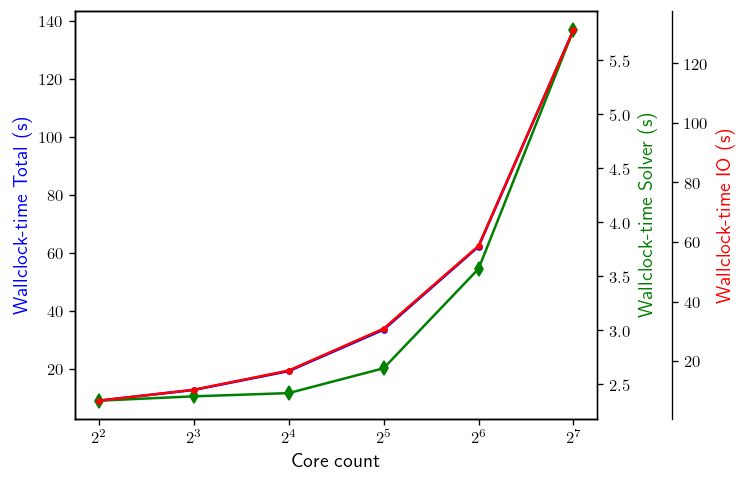

In [84]:
#Data saved from weak scaling study for visualization

core_count = np.array([4, 8, 16, 32, 64, 128], int)

WC_solver = np.array([2.35 , 2.39 , 2.42 , 2.65 , 3.57 , 5.78], float)
WC_IO = np.array([6.72 , 10.38 , 16.83 , 30.91 , 58.67 , 131.15], float)
WC_total = np.array([9.07 , 12.77 , 19.25 , 33.56 ,  62.24 , 136.93],float)

No_cells = np.array([2560 , 5120 , 10240 , 20480 , 40960 , 81920], int)

WC_per_cell_update_solver = WC_solver/No_cells
WC_per_cell_update_total = WC_total/No_cells
WC_per_cell_update_IO = WC_IO/No_cells

fig,  ax1 = plt.subplots(figsize = (6,4.5), dpi = 120, facecolor = 'w')

fig.subplots_adjust(right=0.85)
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 45))

ax1.plot(core_count, WC_total, 'b',marker = '.', label = 'Wallclock-time Total')
ax3.plot(core_count, WC_IO, 'r', marker = '.', label = 'Wallclock-time IO')
ax2.plot(core_count, WC_solver,'g',marker = 'd', label = 'Wallclock-time Solver')
#plt.legend()

ax1.set_xlabel('Core count', fontsize = 12)
ax1.set_xscale('log', basex=2)
ax1.set_ylabel('Wallclock-time Total (s)', fontsize = 12, color='b')
ax3.set_ylabel('Wallclock-time IO (s)', fontsize = 12, color='r')
ax2.set_ylabel('Wallclock-time Solver (s)', fontsize = 12, color='g')

<ipython-input-106-f60041df4f4d>:27: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_xscale('log', basex=2)


Text(0, 0.5, 'CPU seconds per cell update IO (s)')

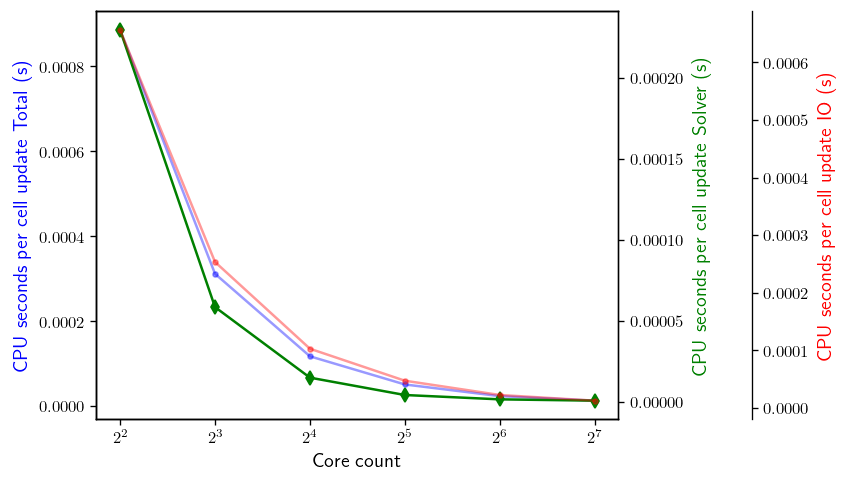

In [106]:
core_count = np.array([4, 8, 16, 32, 64, 128], int)

WC_solver = np.array([2.35 , 2.39 , 2.42 , 2.65 , 3.57 , 5.78], float)
WC_IO = np.array([6.72 , 10.38 , 16.83 , 30.91 , 58.67 , 131.15], float)
WC_total = np.array([9.07 , 12.77 , 19.25 , 33.56 ,  62.24 , 136.93],float)

No_cells = np.array([2560 , 5120 , 10240 , 20480 , 40960 , 81920], int)

WC_per_cell_update_solver = WC_solver/No_cells
WC_per_cell_update_total = WC_total/No_cells
WC_per_cell_update_IO = WC_IO/No_cells

fig,  ax1 = plt.subplots(figsize = (6,4.5), dpi = 120, facecolor = 'w')

fig.subplots_adjust(right=0.85)
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 80))

ax1.plot(core_count, WC_per_cell_update_total/core_count, 'b',marker = '.', label = 'Wallclock-time Total', alpha=0.4)
ax2.plot(core_count, WC_per_cell_update_solver/core_count,'g',marker = 'd', label = 'Wallclock-time Solver')
ax3.plot(core_count, WC_per_cell_update_IO/core_count, 'r', marker = '.', label = 'Wallclock-time IO', alpha=0.4)

#plt.legend()

ax1.set_xlabel('Core count', fontsize = 12)
ax1.set_xscale('log', basex=2)
ax1.set_ylabel('CPU seconds per cell update Total (s)', fontsize = 12, color='b')
ax2.set_ylabel('CPU seconds per cell update Solver (s)', fontsize = 12, color='g')
ax3.set_ylabel('CPU seconds per cell update IO (s)', fontsize = 12, color='r')

<ipython-input-132-bae874adaae0>:14: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_xscale('log',basex = 2)


Text(0, 0.5, 'Service Units')

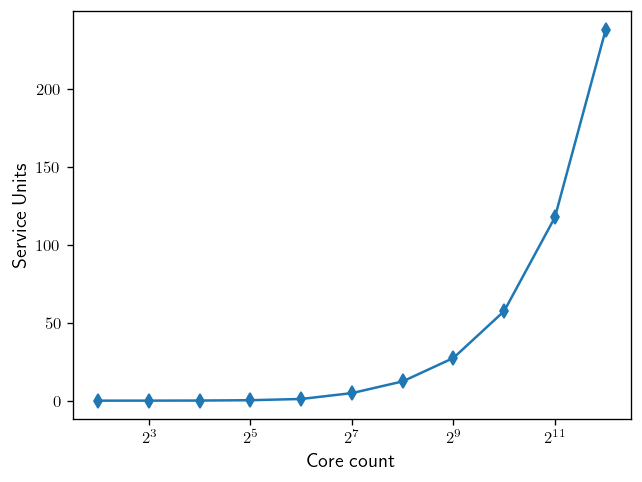

In [132]:
import numpy as np
from scipy import interpolate

x = core_count
y = np.array([0.01 , 0.03 , 0.09 , 0.3 , 1.1 , 4.86 ])
f = interpolate.interp1d(x, y, fill_value='extrapolate')

cores = np.array([4,   8,  16,  32,  64, 128, 256, 512, 1024, 2048, 4096])
SUs = f(cores)


fig,  ax1 = plt.subplots(figsize = (6,4.5), dpi = 120, facecolor = 'w')
ax1.plot(cores, SUs, marker = 'd')
ax1.set_xscale('log',basex = 2)
ax1.set_xlabel('Core count', fontsize = 12)
ax1.set_ylabel('Service Units', fontsize = 12)